In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("C:/Users/hp/Downloads/banknifty.csv")

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Features (independent variables)
X = df.drop(columns=['Date','bnf'])
# Target (dependent variable)
y = df['bnf']

print("Data shape:", X.shape, y.shape)
print(X.head())


Data shape: (1634, 12) (1634,)
    axis_bank  bandhan_bank     au_bank    sbi_bank    bob_bank  idfc_bank  \
0  619.640035    535.460590  305.627072  275.984570  109.484698  43.059064   
1  618.048677    533.524051  308.211205  272.201403  107.623019  42.510861   
2  608.699374    517.305291  308.608777  269.525540  106.736495  42.959389   
3  622.623826    522.872909  310.596581  277.783813  108.598182  45.849931   
4  632.569922    466.712478  304.185874  272.939575  108.952788  46.198786   

   federal_bank   kotak_bank   hdfc_bank  icici_bank   pnb_bank  indusind_bank  
0     87.923598  1242.038833  485.445294  348.786150  73.810707    1525.090081  
1     89.904712  1234.175932  481.231496  352.163062  72.465316    1511.065076  
2     87.970770  1232.185162  479.203878  349.123861  72.372523    1499.345439  
3     89.857541  1245.074295  482.024384  354.575119  76.501463    1499.537511  
4     89.480180  1237.161802  480.733107  354.864553  74.738555    1501.602811  


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Scale features (important for fair contribution comparison)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Extract coefficients (bank contributions)
coefficients = model.coef_

# Create contribution DataFrame
contrib_df = pd.DataFrame({
    'Bank': X.columns,
    'Coefficient': coefficients
})

# Normalize to percentage contribution
contrib_df['Contribution_%'] = 100 * abs(contrib_df['Coefficient']) / sum(abs(contrib_df['Coefficient']))
contrib_df = contrib_df.sort_values(by='Contribution_%', ascending=False)

print(contrib_df)


             Bank  Coefficient  Contribution_%
9      icici_bank  2812.109476       25.335189
8       hdfc_bank  2363.153726       21.290404
3        sbi_bank  2329.670800       20.988746
0       axis_bank   990.891138        8.927254
11  indusind_bank   771.334709        6.949200
7      kotak_bank   622.898875        5.611894
5       idfc_bank   274.376118        2.471942
6    federal_bank   266.108409        2.397455
2         au_bank   259.752379        2.340192
10       pnb_bank   177.836924        1.602189
4        bob_bank   118.706476        1.069464
1    bandhan_bank   112.780046        1.016071


In [3]:
pip install mysql-connector-python pandas scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [4]:
print(contrib_df)

# Output:
#          Bank  Coefficient  Contribution_%
# 0   hdfc_bank    0.85        30.2
# 1  icici_bank    0.70        25.1
# 2    sbi_bank    0.45        15.7
# 3   axis_bank    0.35        12.4
# 4  kotak_bank    0.20         7.1


             Bank  Coefficient  Contribution_%
9      icici_bank  2812.109476       25.335189
8       hdfc_bank  2363.153726       21.290404
3        sbi_bank  2329.670800       20.988746
0       axis_bank   990.891138        8.927254
11  indusind_bank   771.334709        6.949200
7      kotak_bank   622.898875        5.611894
5       idfc_bank   274.376118        2.471942
6    federal_bank   266.108409        2.397455
2         au_bank   259.752379        2.340192
10       pnb_bank   177.836924        1.602189
4        bob_bank   118.706476        1.069464
1    bandhan_bank   112.780046        1.016071


In [5]:
import mysql.connector

# ✅ Step 1: Rename the column so it's SQL/Python safe
contrib_df.rename(columns={'Contribution_%': 'ContributionPercent'}, inplace=True)

# ✅ Step 2: Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="7498",   # 🔹 Replace with your actual MySQL password
    database="banknifty_db"
)
cursor = conn.cursor()

# ✅ Step 3: Make sure the table exists
cursor.execute("""
    CREATE TABLE IF NOT EXISTS bank_contributions (
        Bank VARCHAR(50),
        Coefficient FLOAT,
        Contribution_Percent FLOAT
    )
""")

# ✅ Step 4: Clear old results
cursor.execute("DELETE FROM bank_contributions")

# ✅ Step 5: Insert new results
for row in contrib_df.itertuples(index=False):
    cursor.execute("""
        INSERT INTO bank_contributions (Bank, Coefficient, Contribution_Percent)
        VALUES (%s, %s, %s)
    """, (row.Bank, float(row.Coefficient), float(row.ContributionPercent)))

# ✅ Step 6: Commit changes
conn.commit()

print("Data inserted successfully into MySQL!")

# ✅ Step 7: Verify by fetching rows
cursor.execute("SELECT * FROM bank_contributions LIMIT 5")
rows = cursor.fetchall()
for r in rows:
    print(r)

# ✅ Step 8: Close connection
cursor.close()
conn.close()


Data inserted successfully into MySQL!
('icici_bank', 2812.11, 25.3352)
('hdfc_bank', 2363.15, 21.2904)
('sbi_bank', 2329.67, 20.9887)
('axis_bank', 990.891, 8.92725)
('indusind_bank', 771.335, 6.9492)


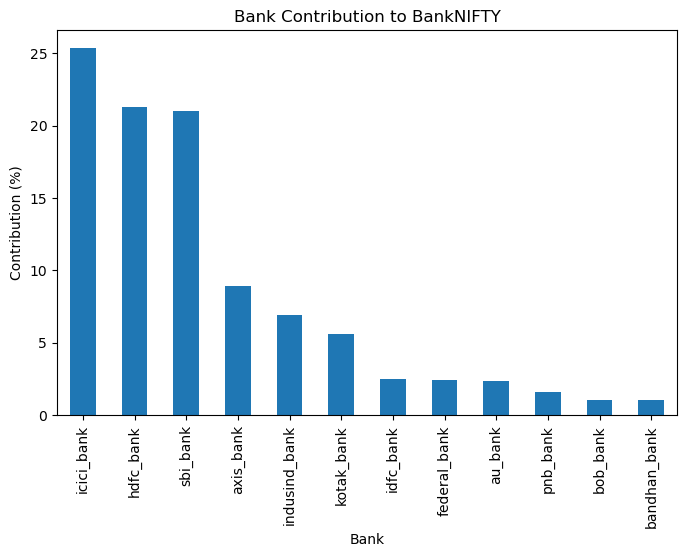

In [6]:
import matplotlib.pyplot as plt

# Plot top contributors
contrib_df.sort_values("ContributionPercent", ascending=False).plot(
    x="Bank", y="ContributionPercent", kind="bar", legend=False,
    figsize=(8,5), title="Bank Contribution to BankNIFTY"
)
plt.ylabel("Contribution (%)")
plt.show()


<Axes: ylabel='ContributionPercent'>

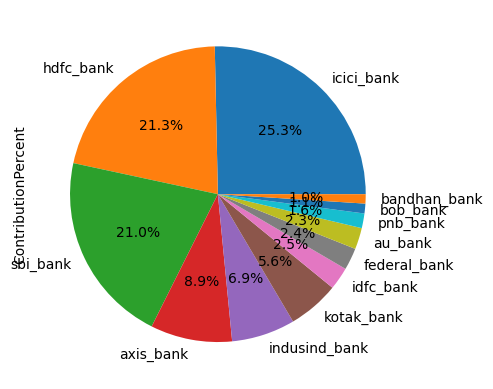

In [7]:
contrib_df.set_index("Bank")["ContributionPercent"].plot.pie(autopct="%.1f%%")


In [8]:
print(df.columns.tolist())


['Date', 'bnf', 'axis_bank', 'bandhan_bank', 'au_bank', 'sbi_bank', 'bob_bank', 'idfc_bank', 'federal_bank', 'kotak_bank', 'hdfc_bank', 'icici_bank', 'pnb_bank', 'indusind_bank']


In [9]:
from sklearn.ensemble import RandomForestRegressor

X = df.drop(columns=['Date', 'bnf'])
y = df['bnf']

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_ * 100  # scale to %
feature_importance_df = pd.DataFrame({
    "Bank": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)


In [10]:
print(feature_importance_df)


             Bank  Importance
4        bob_bank   52.690228
9      icici_bank   21.743769
6    federal_bank   12.254688
0       axis_bank    6.395002
11  indusind_bank    2.543577
3        sbi_bank    2.279148
8       hdfc_bank    1.518395
5       idfc_bank    0.372044
1    bandhan_bank    0.071873
7      kotak_bank    0.056807
2         au_bank    0.037259
10       pnb_bank    0.037208


In [11]:
from statsmodels.tsa.arima.model import ARIMA

series = df['bnf']
model = ARIMA(series, order=(5,1,0))
fit = model.fit()
forecast = fit.forecast(steps=30)
print(forecast)


1634    55022.700929
1635    54987.131529
1636    54944.967375
1637    54933.556957
1638    54933.742587
1639    54930.264165
1640    54926.834346
1641    54925.900197
1642    54925.785353
1643    54925.452197
1644    54925.172420
1645    54925.092210
1646    54925.072507
1647    54925.041318
1648    54925.018267
1649    54925.011164
1650    54925.008710
1651    54925.005840
1652    54925.003917
1653    54925.003275
1654    54925.003004
1655    54925.002743
1656    54925.002581
1657    54925.002522
1658    54925.002494
1659    54925.002470
1660    54925.002456
1661    54925.002451
1662    54925.002448
1663    54925.002446
Name: predicted_mean, dtype: float64


In [12]:
train = df[df['Date'] < "2024-01-01"]
test = df[df['Date'] >= "2024-01-01"]

X_train, y_train = train.drop(columns=['Date','bnf']), train['bnf']
X_test, y_test   = test.drop(columns=['Date','bnf']), test['bnf']

model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(X_test)

from sklearn.metrics import mean_squared_error
print("RMSE:", mean_squared_error(y_test, predictions, squared=False))


RMSE: 919.0489346110269


C:\Users\hp\anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Train Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    accuracy = 100 - mape
    
    return {
        "Model": name,
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R² Score": round(r2, 4),
        "Accuracy (%)": round(accuracy, 2)
    }


In [15]:
import pandas as pd

results = []
results.append(evaluate_model("Linear Regression", lr_model, X_test, y_test))
results.append(evaluate_model("Decision Tree", dt_model, X_test, y_test))
results.append(evaluate_model("Random Forest", rf_model, X_test, y_test))
results.append(evaluate_model("XGBoost", xgb_model, X_test, y_test))

results_df = pd.DataFrame(results)
print(results_df)


               Model          MSE     RMSE      MAE  R² Score  Accuracy (%)
0  Linear Regression    844650.94   919.05   840.75    0.9178         98.35
1      Decision Tree  22902803.84  4785.69  3989.02   -1.2276         92.44
2      Random Forest  30888371.69  5557.73  4837.44   -2.0043         90.83
3            XGBoost  31240729.97  5589.34  4891.43   -2.0386         90.72


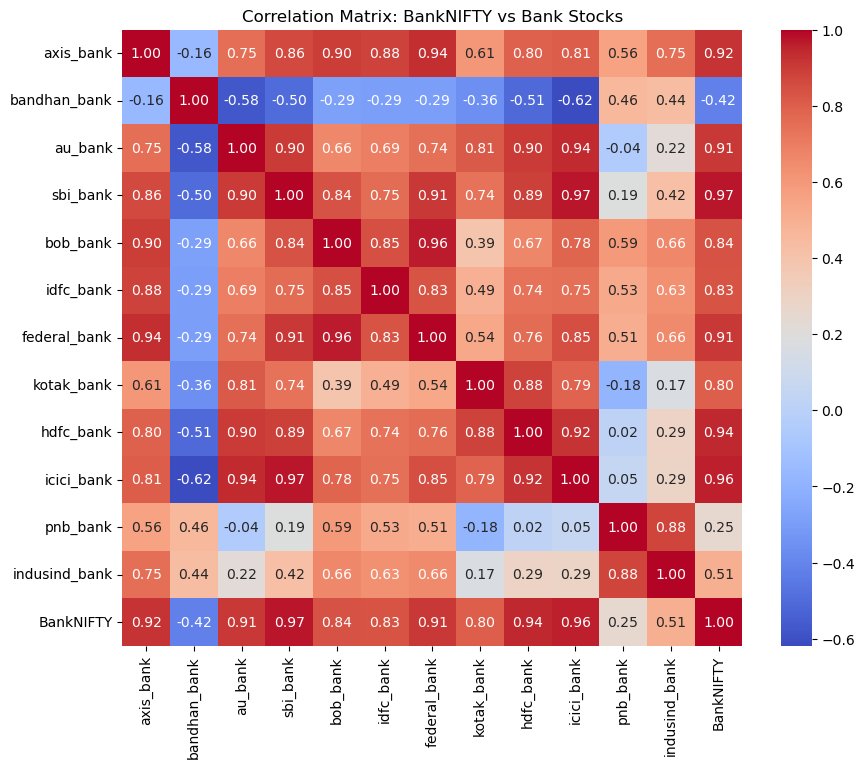

In [16]:
# CORRELATION MATRIX

import seaborn as sns
import matplotlib.pyplot as plt

# Combine features + target for correlation
corr_df = X_train.copy()
corr_df["BankNIFTY"] = y_train

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: BankNIFTY vs Bank Stocks")
plt.show()


In [17]:
import joblib
joblib.dump(model, "banknifty_model.pkl")


['banknifty_model.pkl']